# Dielectric disc

This code will calculate the modes of a dielectric disc. This is calculated using a surface equivalent problem, where the solution is represented by equivalent surface currents of electric type "J" and magnetic type "M". This results in an impedance matrix of the following form:

$$\begin{bmatrix}E_{inc} \\ H_{inc}\end{bmatrix} =
\begin{bmatrix} Z_{EJ} & Z_{EM} \\ Z_{HJ} & Z_{HM}\end{bmatrix}
\begin{bmatrix}J \\ M\end{bmatrix}
$$

Compared to examples with PEC objeccts, the calculations are considerably slower (this will hopefully be improved in a future version).

In [1]:
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt

import os.path as osp
import numpy as np

import openmodes
from openmodes.material import IsotropicMaterial
from openmodes.operator.penetrable import PMCHWTOperator, CTFOperator
from openmodes.sources import PlaneWaveSource
from openmodes.integration import RectangularContour, EllipticalContour, ExternalModeContour, DunavantRule, GaussLegendreRule

Uncomment the lines below to see more information about the internal workings of OpenModes, including which parts of the simulation are taking the most time.

In [2]:
# import logging
# logging.getLogger().setLevel(logging.INFO)

Since we are solving a surface equivalent problem for a dielectric object, we need to change the operator that we solve. The operator we are using here is the "Combined Tangential Form", as defined in [Ylä-Oijala et al, Radio Sci. 40, RS6002 (2005)](http://dx.doi.org/10.1029/2004RS003169). This operator is specified by the option `operator_class=CTFOperator` when creating the `Simulation` object.

In [3]:
sim = openmodes.Simulation(operator_class=CTFOperator, notebook=True)

When placing the part into the simulation, in addition to specifying the mesh, we also need to indicate which material the part will be made from. Here we use a simple model for silicon, as a non-dispersive material with a refractive index of 3.53 (note that it is squared to give the permittivity).

In [4]:
parameters={'radius':242e-9, 'height':220e-9, 'mesh_tol':75e-9, 'rounding':50e-9}
cross_section = 2*np.pi*parameters['radius']**2
mesh = sim.load_mesh(osp.join(openmodes.geometry_dir, 'cylinder_rounded.geo'), parameters=parameters)

material = IsotropicMaterial("Silicon", 3.53**2, 1)

part = sim.place_part(mesh, material=material)

## Calculate extinction directly

In [5]:
pw = PlaneWaveSource([0, 1, 0], [0, 0, 1], p_inc=1.0)

num_freqs = 100

freqs = np.linspace(100e12, 300e12, num_freqs)
extinction = np.empty(num_freqs, np.complex128)

for freq_count, s in sim.iter_freqs(freqs, log_skip=20):
    Z = sim.impedance(s)
    V = sim.source_vector(pw, s)
    I = Z.solve(V)
    V_E = sim.source_vector(pw, s, extinction_field=True)
    extinction[freq_count] = np.vdot(V_E, I)    

## Find modes

In [6]:
contour = ExternalModeContour(-5.45e14+2j*np.pi*350e12, avoid_origin=0.5e14, integration_rule=GaussLegendreRule(15))
estimates = sim.estimate_poles(contour)

Here the estimated frequencies of the poles are shown. Also plotted is the contour around which integration was performed in order to obtain the estimates of the poles.

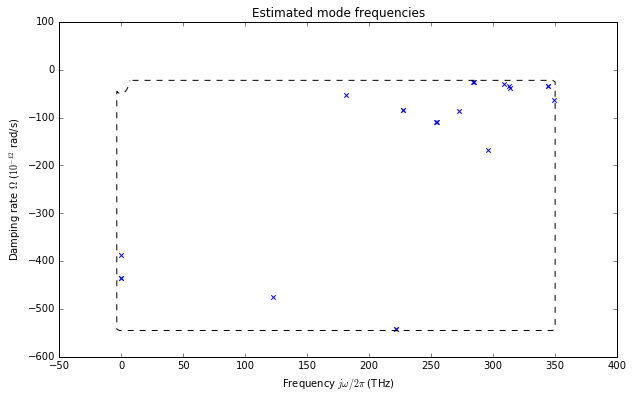

In [7]:
contour_points = np.fromiter((p for p, w in contour), np.complex128)#, len(contour))

fig = plt.figure(figsize=(10, 6))
plt.scatter(estimates.s.imag*1e-12/2/np.pi, estimates.s.real*1e-12, marker='x')
plt.plot(contour_points.imag*1e-12/2/np.pi, contour_points.real*1e-12, 'k--')
plt.xlabel('Frequency $j\omega/2\pi$ (THz)')
plt.ylabel('Damping rate $\Omega$ ($10^{-12}$ rad/s)')
plt.title("Estimated mode frequencies")
plt.show()

In [8]:
print("Found {} modes".format(len(estimates)))

Found 21 modes


In [9]:
refined = sim.refine_poles(estimates, max_iter=10)

## Show complex frequencies of modes

For comparison purposes, the modes are shown after refinement. Note that in some cases modes which were estimated may be missing, due to the iterative search failing to converge.

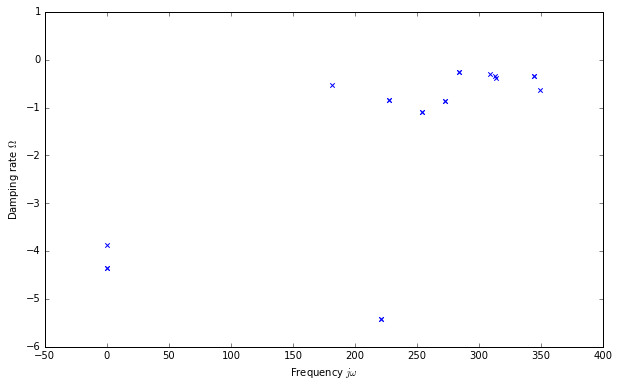

In [10]:
fig = plt.figure(figsize=(10, 6))
points = plt.scatter(refined.s.imag*1e-12/2/np.pi, refined.s.real*1e-14, marker='x')
plt.xlabel('Frequency $j\omega$')
plt.ylabel('Damping rate $\Omega$')
plt.show()

## Plot modes

The equivalent surfaces currents of the modes are plotted here. Note that both electric current "J" and magnetic current "M" may be plotted, and can reveal different information about modes. Also note that for some modes the real or imaginary parts of the current may be very small, so try selecting both options from the drop-down box.

In [11]:
mode = 6
which_current = "M"
print("Surface current {} of mode with frequency {:.2f} THz".format(which_current, refined.s[0, mode].imag/2/np.pi*1e-12))
sim.plot_3d(solution=refined.vr[which_current, :, 'modes', mode])


Surface current M of mode with frequency 227.17 THz


## Calculate extinction by modes

In [12]:
full_modes = refined.add_conjugates()
len(full_modes)

37

In [13]:
num_modes = len(full_modes)
extinction_modes = np.empty((num_freqs, num_modes), np.complex128)

vr = full_modes.vr
vl = full_modes.vl

for freq_count, s in sim.iter_freqs(freqs, log_skip=20):
    V = sim.source_vector(pw, s)
    V_E = sim.source_vector(pw, s, extinction_field=True)
    
    I_modes = (1/(s - full_modes.s) + 1/full_modes.s)*vl.dot(V)
    extinction_modes[freq_count] = V_E.vdot(vr*I_modes)


The plot below shows the contribution of each mode to the total extinction of the disc. Note that in some cases there are negative contributions, indicating destructive interference between modes.

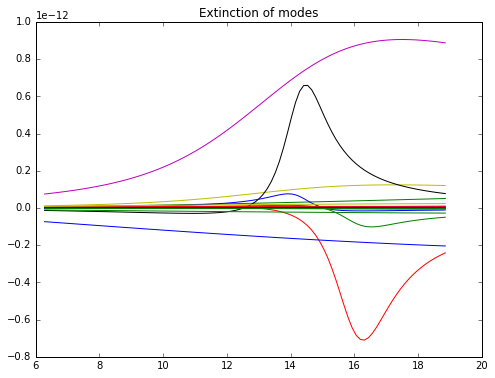

In [14]:
fig = plt.figure(figsize=(8, 6))
plt.plot(freqs*1e-14*2*np.pi, extinction_modes.real)
plt.title('Extinction of modes')
plt.show()

To see how good the model is, we compare the extinction calculated from the modes with that obtained directly, and find good agreement.

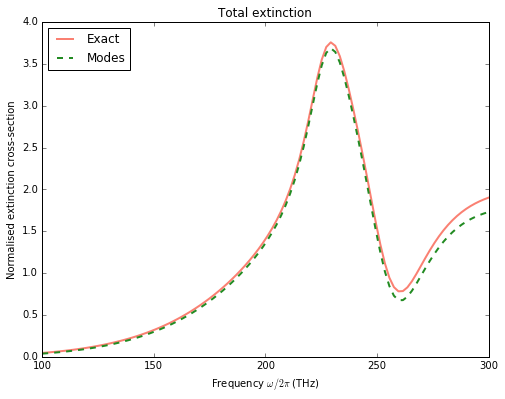

In [15]:
fig = plt.figure(figsize=(8, 6))
plt.plot(freqs*1e-12, extinction.real/cross_section, linewidth=2, color='salmon')
plt.plot(freqs*1e-12, np.sum(extinction_modes.real, axis=1)/cross_section, '--', linewidth=2, color="forestgreen")
plt.legend(("Exact", "Modes"), loc="upper left")
plt.title("Total extinction")
plt.xlabel('Frequency $\omega/2\pi$ (THz)')
plt.ylabel("Normalised extinction cross-section")
plt.show()